In [1]:
import pickle
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [2]:
# Load training and validation datasets
train_pd, val_pd, test_pd = {}, {}, {}
train_pd['rock'] = pd.read_csv('datasets/raw/rock_train.csv')
train_pd['paper'] = pd.read_csv('datasets/raw/paper_train.csv')
train_pd['scissors'] = pd.read_csv('datasets/raw/scissors_train.csv')
val_pd['rock'] = pd.read_csv('datasets/raw/rock_val.csv')
val_pd['paper'] = pd.read_csv('datasets/raw/paper_val.csv')
val_pd['scissors'] = pd.read_csv('datasets/raw/scissors_val.csv')

# Load test datasets
## test_0.csv, test_1.csv, test_2.csv each includes a recording a single gesture.
## test_combined.csv includes a recording of changing gestures.
for i in range(3):
    test_pd[i] = pd.read_csv('datasets/raw/test_'+str(i)+'.csv')
test_combined_pd = pd.read_csv('datasets/raw/test_combined.csv')

In [3]:
# Parameters
LABELS = ['rock', 'paper', 'scissors']
finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
dim_names = 'xyz'
joint_names = []
for f in range(5):
    for b in range(5):
        for d in range(3):
            joint_name = finger_names[f]+'-'+str(b)+'-'+dim_names[d]
            joint_names.append(joint_name)  
#print(test_combined_pd)

In [4]:
# Functions for processing datasets
def shift_origin(data_pd):
    """
    Shift coordinates of all joints with respect to the joint Thumb-0.
    Inputs:
        - data_pd: DataFrame. 
    Outputs:
        - shifted_data_pd: DataFrame with coordinate data shifted.        
    """
    
    test_combined_numpy = data_pd.to_numpy(copy=False) # do everything in-place
    #print(data_pd)
    thumb_0_x = test_combined_numpy[:,1]
    thumb_0_y = test_combined_numpy[:,2]
    thumb_0_z = test_combined_numpy[:,3]

    new_x = test_combined_numpy[:,1::3]-thumb_0_x[:, np.newaxis]
    new_y = test_combined_numpy[:,2::3]-thumb_0_y[:, np.newaxis]
    new_z = test_combined_numpy[:,3::3]-thumb_0_z[:, np.newaxis]

    test_combined_numpy[:,1::3] = new_x
    test_combined_numpy[:,2::3] = new_y
    test_combined_numpy[:,3::3] = new_z
    return data_pd

def cut_head_tail(data_pd, head_len=500, data_len=6000):
    """
    Cut the head and tail of recorded data for sanity.
    Inputs:
        - data_pd: DataFrame.
        - head_len: the length of head dropped.
        - data_len: the length of the kept data.
    Outputs:
        - cut_data_pd: 
            None, if the length including head_len and data_len exceeds the length of data_pd;
            otherwise, DataFrame with head cut and the length of data_len.
    """
    #print(f"data_len: {data_len}, head_len {head_len}, act {data_pd.shape}")
    if (head_len + data_len) > data_pd.shape[0]: # TODO! is this completly right +-1
        print("Cut to much data")
        return None
    cut_data_pd = data_pd.drop([i for i in range(head_len)])
    cut_data_pd.reset_index(drop=True , inplace=True)
    cut_data_pd = cut_data_pd.drop([i for i in range(data_len,cut_data_pd.shape[0])])
    cut_data_pd.reset_index(drop=True, inplace=True)
    assert(cut_data_pd.shape[0]== data_len)
    return cut_data_pd

def concat_different_labels(data_pd_dict):
    """
    Form a unified DataFrame with all labels included.
    Inputs:
        - data_pd_dict: Dictionary
            - ['rock']: DataFrame with rock label.
            - ['paper']: DataFrame with paper label.
            - ['scissors']: DataFrame with scissors label.
    Outputs:
        - concatenated_data_pd: DataFrame with all labels included.
    """
    return pd.concat([data_pd_dict['rock'], data_pd_dict['paper'], data_pd_dict['scissors']])
    
def split_features_label(data_pd):
    """
    Split DataFrame into features (X) and label (y).
    Inputs:
        - data_pd: DataFrame.
    Outputs:
        - X: feature data. numpy array with shape (num_samples, num_features), where num_features should be 69.
        - y: label data. numpy array with shape (num_samples,).
    """
    hasLabel = (data_pd.shape[1] == 77)
    if hasLabel: 
        X = data_pd.to_numpy(copy=True)[:,6+1:-1] # remove time and 6 columns, in addition remove label
        Y = data_pd.to_numpy(copy=True) [:,-1]
    else:
        X = data_pd.to_numpy(copy=True)[:,6 + 1 :]
        Y = np.zeros(X.shape[0])
    assert(X.shape[1] == 69)
    assert(X.shape[0] == Y.shape[0])
    return X, Y

In [6]:
# Process datasets
processed_train_pd = {}
processed_val_pd = {}
processed_test_pd = {}
for label in LABELS:
    processed_train_pd[label] = cut_head_tail(train_pd[label], head_len=500, data_len=6000)
    processed_train_pd[label] = shift_origin(processed_train_pd[label])
    processed_train_pd[label]['label'] = label
    processed_val_pd[label] = cut_head_tail(val_pd[label], head_len=100, data_len=1500)
    processed_val_pd[label] = shift_origin(processed_val_pd[label])
    processed_val_pd[label]['label'] = label
    
train_data = concat_different_labels(processed_train_pd)
X_train, y_train = split_features_label(train_data)
val_data = concat_different_labels(processed_val_pd)
X_val, y_val = split_features_label(val_data)

X_test = {}
for i in range(3):
    processed_test_pd[i] = cut_head_tail(test_pd[i], head_len=100, data_len=1500)
    processed_test_pd[i] = shift_origin(processed_test_pd[i])
    X_test[i], _ = split_features_label(processed_test_pd[i])


processed_test_combined_pd = shift_origin(test_combined_pd)
X_test_combined, _ = split_features_label(processed_test_combined_pd)

In [7]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test_combined = scaler.transform(X_test_combined)
for i in range(3):
    X_test[i] = scaler.transform(X_test[i])

In [8]:
def train_validate_model(X_train, y_train, X_val, y_val):
    """
    Train and validate a logistic regression model for hand gesture classifier.
    Inputs:
        - X_train: feature data of training dataset. numpy array with shape (num_train_samples, num_features).
        - y_train: label data of training dataset. numpy array with shape (num_train_samples,).
        - X_val: feature data of validation dataset. numpy array with shape (num_val_samples, num_features).
        - y_val: label data of validation dataset. numpy array with shape (num_val_samples,).
    Outputs:
        - model: logistic regression model.
        - train_accuracy
        - val_accuracy
    """

    model = LogisticRegression(random_state=0).fit(X_train, y_train)
    train_accuracy = model.score(X_train, y_train)
    val_accuracy = model.score(X_val, y_val)
    return model, train_accuracy, val_accuracy


In [9]:
model, train_accuracy, val_accuracy = train_validate_model(X_train, y_train, X_val, y_val)
print('Training accuracy: {0:.2f}%'.format(100 * train_accuracy))
print('Validation accuracy: {0:.2f}%'.format(100 * val_accuracy))

Training accuracy: 100.00%
Validation accuracy: 98.38%


In [54]:
def single_hand_gesture_recognition(model, X_test_single, LABELS):
    """
    Train and validate a logistic regression model for hand gesture classifier.
    Inputs:
        - model: logistic regression model
        - X_test_single: feature data of test dataset with a single ground truth label. \
            numpy array with shape (num_test_samples, num_features).
        - LABELS: ['rock', 'paper', 'scissors']
    Outputs:
        - hand_gesture: string. 'rock', 'paper', or 'scissors'.
    """
    print(X_test_single.shape)
    res = model.predict(X_test_single)
    (unique, counts) = np.unique(res, return_counts=True)
    print(f"Unique {unique}, counts: {counts}")
    index = np.argmax(counts)
    return unique[index]

def offline_hand_gesture_classifer_and_visualizer(model, X_test_combined, LABELS, label_colors):
    """
    Classify the hand gesture at each time step and visualize the probability distribution over potential \
    hand gestures at each time step.
    Inputs:
        - model: logistic regression model
        - X_test_combined: time series feature data of test dataset with changing hand gesture labels. \
            numpy array with shape (num_test_combined_samples, num_features).
        - LABELS: ['rock', 'paper', 'scissors']
        - label_colors:
            -['rock']: 'r'
            -['paper']: 'y'
            -['scissors']: 'b'
    Outputs:
        - Plot the probability distribution over potential hand gestures at each time step.
    """
    fig, ax = plt.subplots()
    props = model.predict_proba(X_test_combined)
    for i, label in enumerate(model.classes_):
        plt.plot(props[:,i], c = label_colors[label] , label=label)

    ax.legend()
    plt.show()
    return

In [55]:
for i in range(3):
    X_test_single = X_test[i]
    hand_gesture = single_hand_gesture_recognition(model, X_test_single, LABELS)
    print("The hand gesture in test_"+str(i)+".csv is "+hand_gesture+".")

(1500, 69)
Unique ['paper'], counts: [1500]
The hand gesture in test_0.csv is paper.
(1500, 69)
Unique ['scissors'], counts: [1500]
The hand gesture in test_1.csv is scissors.
(1500, 69)
Unique ['rock'], counts: [1500]
The hand gesture in test_2.csv is rock.


(3503, 3)
['paper' 'paper' 'paper' ... 'scissors' 'scissors' 'scissors']

['rock', 'paper', 'scissors']


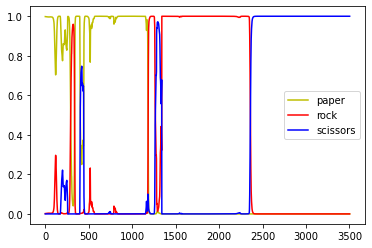

In [56]:
label_colors = {'rock': 'r', 'paper': 'y', 'scissors': 'b'}
offline_hand_gesture_classifer_and_visualizer(model, X_test_combined, LABELS, label_colors)

In [ ]:
# Save the trained model.
model_folder = 'models'
filename = 'lr_rock_paper_scissors.pkl'
with open(join(model_folder, filename), 'wb') as f:
    pickle.dump(model, f)
    print(join(model_folder, filename)+" is saved.")